### Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score
import time

### Define Paths

In [2]:
train_dir = 'train.csv'
test_dir = 'test.csv'
submission_dir = 'submission.csv'

### Read data

In [3]:
train = pd.read_csv(train_dir)
test = pd.read_csv(test_dir)
train.head()

,id,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
0,0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0


### Fill Missing Value

In [4]:
missing_col = ['MO HLADR+ MFI (cells/ul)','Neu CD64+MFI (cells/ul)','Mono CD64+MFI (cells/ul)']

for col in missing_col:
    ### One missing row only
    
    filled_value = train[train['label'] == 0][col].mean()
    
    train[col] = train[col].fillna(filled_value)

### Data Augmentation

In [5]:
### The number of label==0 and label==1 is not the same,
### Use re-sampling to get more data with positive label

sm = SMOTE(random_state = 666)
train,y = sm.fit_resample(train[[i for i in train.columns if i not in['id','label']]], train['label'])
train['label'] = y
print(train.shape,train['label'].sum())

(116, 12) 58


### Age Transformation

In [6]:
def transform_age(age):
    return age // 5

train['Age'] = train['Age'].apply(transform_age)
test['Age'] = test['Age'].apply(transform_age)

### One-Hot Encoding

In [7]:
train['Sex 0M1F'] = train['Sex 0M1F'].astype(str)
test['Sex 0M1F'] = test['Sex 0M1F'].astype(str)

train[['IsMale','IsFemale']] = pd.get_dummies(train['Sex 0M1F'])
test[['IsMale','IsFemale']] = pd.get_dummies(test['Sex 0M1F'])

train = train.drop('Sex 0M1F',axis=1)
test = test.drop('Sex 0M1F',axis=1)
# pd.get_dummies(train['Age'])

### Normalization

In [8]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
columns = ['MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)',
       'CD3+T (cells/ul)', 'CD8+T (cells/ul)', 'CD4+T (cells/ul)',
       'NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'Mono CD64+MFI (cells/ul)']

scaler.fit(train[columns])

train[columns] = scaler.transform(train[columns])
test[columns] = scaler.transform(test[columns])

In [9]:
X_train,y_train = train[[i for i in train.columns if i not in['id','label']]],train['label']
                        
X_test = test[[i for i in train.columns if i not in['id','label']]]

### Find the best model using Grid Search + Cross Validation

In [10]:
# Random Forest
parameters = {'criterion':('gini','entropy'), 'min_samples_split':[2,5,10],
             'min_samples_leaf':[1,2,5],'max_features':["auto", "sqrt", "log2"],
             'oob_score':[True,False],'class_weight':["balanced","balanced_subsample"]}

rf = RandomForestClassifier(200,random_state = 39)

clf = GridSearchCV(rf, parameters,cv = 10)

clf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=39),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ('gini', 'entropy'),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'oob_score': [True, False]})

### Performance on Training data 

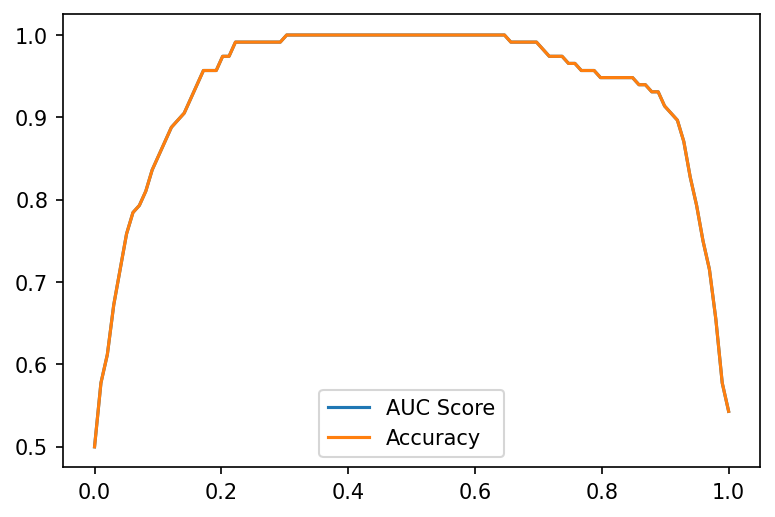

In [11]:
score = []
accuracy = []

for threshold in np.linspace(0,1,100):
    predicted_proba = clf.predict_proba(X_train)

    y_pred = (predicted_proba [:,1] >= threshold).astype('int')
    
    score.append(roc_auc_score(y_train, y_pred))
    accuracy.append(accuracy_score(y_train, y_pred))
    
plt.figure(figsize = [6,4],dpi = 150)
plt.plot(np.linspace(0,1,100),score, label = 'AUC Score')
plt.plot(np.linspace(0,1,100),accuracy,label='Accuracy')
plt.legend()

In [12]:
threshold = 0.5

predicted_proba = clf.predict_proba(X_train)

y_pred = (predicted_proba [:,1] >= threshold).astype('int')

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        58

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



### Predict on Test Data and output submission

In [13]:
predicted_proba = clf.predict_proba(X_test)

prediction = (predicted_proba [:,1] >= threshold).astype('int')

time_stamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

pd.DataFrame({"id":range(59),"label":prediction}).to_csv("submission_"+time_stamp+"_.csv",index=None)